In [107]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import random
import types

In [108]:
train_dir="./ml-100k/u1.base"
test_dir="./ml-100k/u1.test"

In [109]:
#读取数据
def readData(dir):
    data=[]
    with open(dir,"r") as file:
        for line in file:
            x=line
            tuple=[int(x.split()[0]),int(x.split()[1]),int(x.split()[2])]
            data.append(tuple)            
        return data
    
#用于把数据转换为数据,没有评分的设置为0
def getMatrix(data,user_num,item_num):
    R=np.zeros((user_num,item_num))
    for tuple in data:
        R[tuple[0]-1][tuple[1]-1]=tuple[2]
    return R
        

In [110]:
train_data=readData(train_dir)
test_data=readData(test_dir)

In [111]:
usr_num=np.max(train_data,0)[0]
item_num=np.max(train_data,0)[1]
R=getMatrix(train_data,usr_num,item_num)
R_test=getMatrix(test_data,usr_num,item_num) 

In [144]:
def loss(R,P,Q):   
    usr_num=R.shape[0]
    item_num=R.shape[1]
    e=0
    x=(R>0)  #大于0的代表初始矩阵已经存在的评分
    loss=np.multiply(np.square(R-np.dot(P,Q)),x) #筛选出有评分的 
    loss=np.sum(loss) #计算loss总和
    total=np.sum(x)  #把有评分的部分加起来
    return loss/total


#lamda：正则项
def matrix_factorization(R,K,step,lamda,validation_data):
    usr_num=R.shape[0]
    item_num=R.shape[1]
    P=np.random.rand(usr_num,K)
    Q=np.random.rand(K,item_num)
    last_loss=loss(validation_data,P,Q)
    validation_loss=[last_loss]
    for s in range(step):
        '''
        for i in range(usr_num):
            tmp=Q                 #对P的每一行令偏导为0，求出闭式解
            inv=np.linalg.inv(np.dot(tmp,np.transpose(tmp))+lamda*np.eye(K))
            mul=np.dot(R[i,:],np.transpose(Q))
            P[i,:]=np.dot(mul,inv)
        for j in range(item_num):
            tmp=P              #对Q的每一列令偏导为0，求出闭式解
            inv=np.linalg.inv(np.dot(np.transpose(tmp),tmp)+lamda*np.eye(K))
            mul=np.dot(inv,np.transpose(tmp))
            Q[:,j]=np.dot(mul,R[:,j])      
            '''
        #print(s)
        for u in range(usr_num):
            sum1=0
            sum2=0
            for i in range(item_num):
                if(R[u,i]!=0):  #求闭式解，闭式解分为两部分求和，最后两个做矩阵乘法
                    tmp=Q[:,i].reshape((K,1))
                    sum1+=R[u,i]*np.transpose(tmp)                   
                    sum2+=np.dot(tmp,np.transpose(tmp))
            if(type(sum1) is type(0)): #如果sum1==0，证明这一列没有评分，则过滤掉
                continue
            sum2+=lamda*np.eye(K)
            P[u,:]=np.dot(sum1,np.linalg.inv(sum2)).reshape((K))
            
        for i in range(item_num):
            sum1=0
            sum2=0
            for u in range(usr_num):
                if(R[u,i]!=0):  #求闭式解
                    tmp=P[u,:].reshape((1,K))
                    sum1+=R[u,i]*np.transpose(tmp)
                    sum2+=np.dot(np.transpose(tmp),tmp)
            if(type(sum1) is type(0)): #如果sum1==0
                continue
            sum2+=lamda*np.eye(K)
            
            Q[:,i]=np.dot(np.linalg.inv(sum2),sum1).reshape((K))
            
        #loss不带正则项，如果要看带正则项的，可以加上注释那段
        loss_val=loss(validation_data,P,Q) #np.sum(np.square(Q))*lamda/2+np.sum(np.square(P))*lamda/2
        if(abs(loss_val-last_loss)<0.00001):
            return P,Q,validation_loss
        last_loss=loss_val
        validation_loss.append(loss_val)
        
        #print(loss_val)
    return P,Q,validation_loss




            
        

In [146]:
#以下的R是测试算法准确性时候用的
'''
R = [
     [5,9,0,1],
     [4,0,0,1],
     [7,1,0,5],
     [1,0,3,4],
     [0,1,5,4],
    ]
R=np.array(R)
R_test=R
'''
K=2
lamda=0.02
step=20

P,Q,validation_loss=matrix_factorization(R,K,step,lamda,R_test)

In [167]:
def matrix_factorization_stochastic(R,alpha,K,step,lamda,validation_data):
    usr_num=R.shape[0]
    item_num=R.shape[1]
    P=np.random.rand(usr_num,K)  #初始化
    Q=np.random.rand(K,item_num) #初始化
    last_loss=loss(validation_data,P,Q)
    validation_loss=[last_loss]
    record_size=len(train_data)
    for i in range(step):
        sample_index=random.randint(0,record_size-1)
        user=train_data[sample_index][0]-1
        item=train_data[sample_index][1]-1
        sample=train_data[sample_index][2]
        
        e=R[user,item]-np.dot(P[user,:],Q[:,item])
         
        P[user,:]=P[user,:]+2*alpha*e*np.transpose(Q[:,item])-alpha*lamda*P[user,:]
        Q[:,item]=Q[:,item]+2*alpha*e*np.transpose(P[user,:])-alpha*lamda*Q[:,item]
        '''
        for k in range(K):                  #正常做法       
            P[user,k]=P[user,k]+2*alpha*e*Q[k,item]-alpha*lamda*P[user,k]  
            Q[k,item]=Q[k,item]+2*alpha*e*P[user,k]-alpha*lamda*Q[k,item]
        '''
        
        loss_val=loss(validation_data,P,Q)#np.sum(np.square(Q))*lamda/2+np.sum(np.square(P))*lamda/2
        validation_loss.append(loss_val)
        #if(abs(loss_val-last_loss)<0.00001):
           #return P,Q,validation_loss
        last_loss=loss_val
        #print(loss_val)
    return P,Q,validation_loss

In [195]:
'''
R = [
     [5,3,0,1],
     [4,0,0,1],
     [1,1,0,5],
     [1,0,0,4],
     [0,1,5,4],
    ]
R=np.array(R)
R_test=R
'''
alpha=0.05
K=2
lamda=0.01
step=6000

P_g,Q_g,validation_loss_g=matrix_factorization_stochastic(R,alpha,K,step,lamda,R_test)

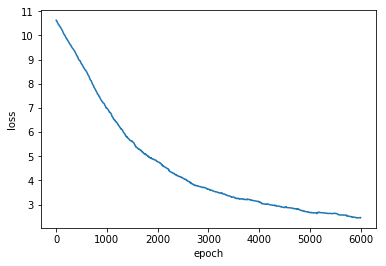

In [196]:
#梯度下降所画的图
plt.figure()
iter=range(len(validation_loss_g))
plt.plot(iter,validation_loss_g)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [172]:
#梯度下降方法所求出来的P和Q
print(np.dot(P_g,Q_g))
print(R)

[[ 2.4880292   1.60445927  1.51652102 ...,  1.08689537  0.68686628
   1.29964847]
 [ 2.00643312  1.24855951  1.26574394 ...,  0.97676967  0.58298353
   1.01582575]
 [ 0.82264213  0.49036047  0.53929095 ...,  0.44814305  0.25284534
   0.4011558 ]
 ..., 
 [ 1.0610092   0.72281813  0.61029322 ...,  0.37812384  0.26815539
   0.58169755]
 [ 2.06866832  1.35707368  1.23916423 ...,  0.85272245  0.5563135
   1.09699079]
 [ 1.6053551   0.9878959   1.02318164 ...,  0.80602591  0.47355382
   0.8048812 ]]
[[ 5.  3.  4. ...,  0.  0.  0.]
 [ 4.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 5.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  5.  0. ...,  0.  0.  0.]]


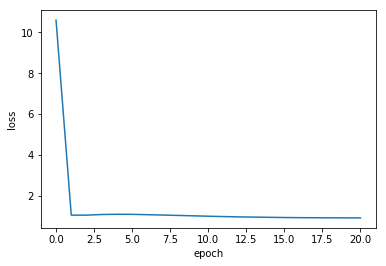

[[ 3.87180703  3.00039307  3.00816366 ...,  2.14636237  3.57528487
   3.23981588]
 [ 4.01355499  3.1897772   3.12378823 ...,  2.1817289   3.64230807
   3.2678651 ]
 [ 3.32226228  2.51263539  2.57692402 ...,  1.87534635  3.11752971
   2.85044745]
 ..., 
 [ 4.28957355  3.45004825  3.34144199 ...,  2.30954674  3.85994907
   3.4460278 ]
 [ 4.54584208  3.96706323  3.56254528 ...,  2.27861549  3.84089986
   3.29791492]
 [ 3.88658811  3.12393481  3.02739109 ...,  2.09366079  3.49892881
   3.12456384]]
[[ 5.  3.  4. ...,  0.  0.  0.]
 [ 4.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 5.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  5.  0. ...,  0.  0.  0.]]


In [147]:
#als算法运算之后所得到的loss图和PQ的积
plt.figure()
iter=range(len(validation_loss))
plt.plot(iter,validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
print(np.dot(P,Q))
print(R)
#error(R,P,Q)